Victor Hugo de Paula

# Otimização da Distribuição de Produtos Essenciais em Grandes Cidades

## Introdução e Contextualização

Grandes centros urbanos enfrentam desafios complexos e interconectados. Dois dos mais prementes são a transição para sistemas de transporte mais sustentáveis e a necessidade de respostas rápidas e eficazes a emergências sanitárias. Este notebook aborda a otimização da distribuição de dois produtos essenciais em cidades simuladas (São Francisco, Nova Délhi e Pequim), buscando equilibrar cobertura de áreas críticas, sustentabilidade, custos e limitações operacionais.

**Produto A:** Estações de infraestrutura sustentável (ex: pontos de recarga para veículos elétricos, bicicletas compartilhadas).

**Produto B:** Kits médicos de emergência.

Será utilizada uma abordagem de **algoritmo guloso** para encontrar uma solução eficiente, embora não necessariamente ótima globalmente.

## Estrutura do notebook

1.  **Definição das Entradas:** Modelagem das cidades, demandas, custos e restrições.
2.  **Modelagem dos Produtos:** Classes `ProdutoA` e `ProdutoB`.
3.  **Função de Pontuação Composta:** Definição da métrica de sucesso.
4.  **Estratégias Gulosas:** Proposição e justificação da escolha.
5.  **Pseudocódigo e Complexidade:** Detalhamento do algoritmo e análise teórica.
6.  **Implementação:** Código Python.
7.  **Simulação e Visualização:** Aplicação do algoritmo nas cidades e apresentação dos resultados (`plotly`, `networkx`).
8.  **Análise Crítica:** Limitações da abordagem gulosa e cenários de falha.
9.  **Discussão:** Compromissos assumidos pela estratégia.

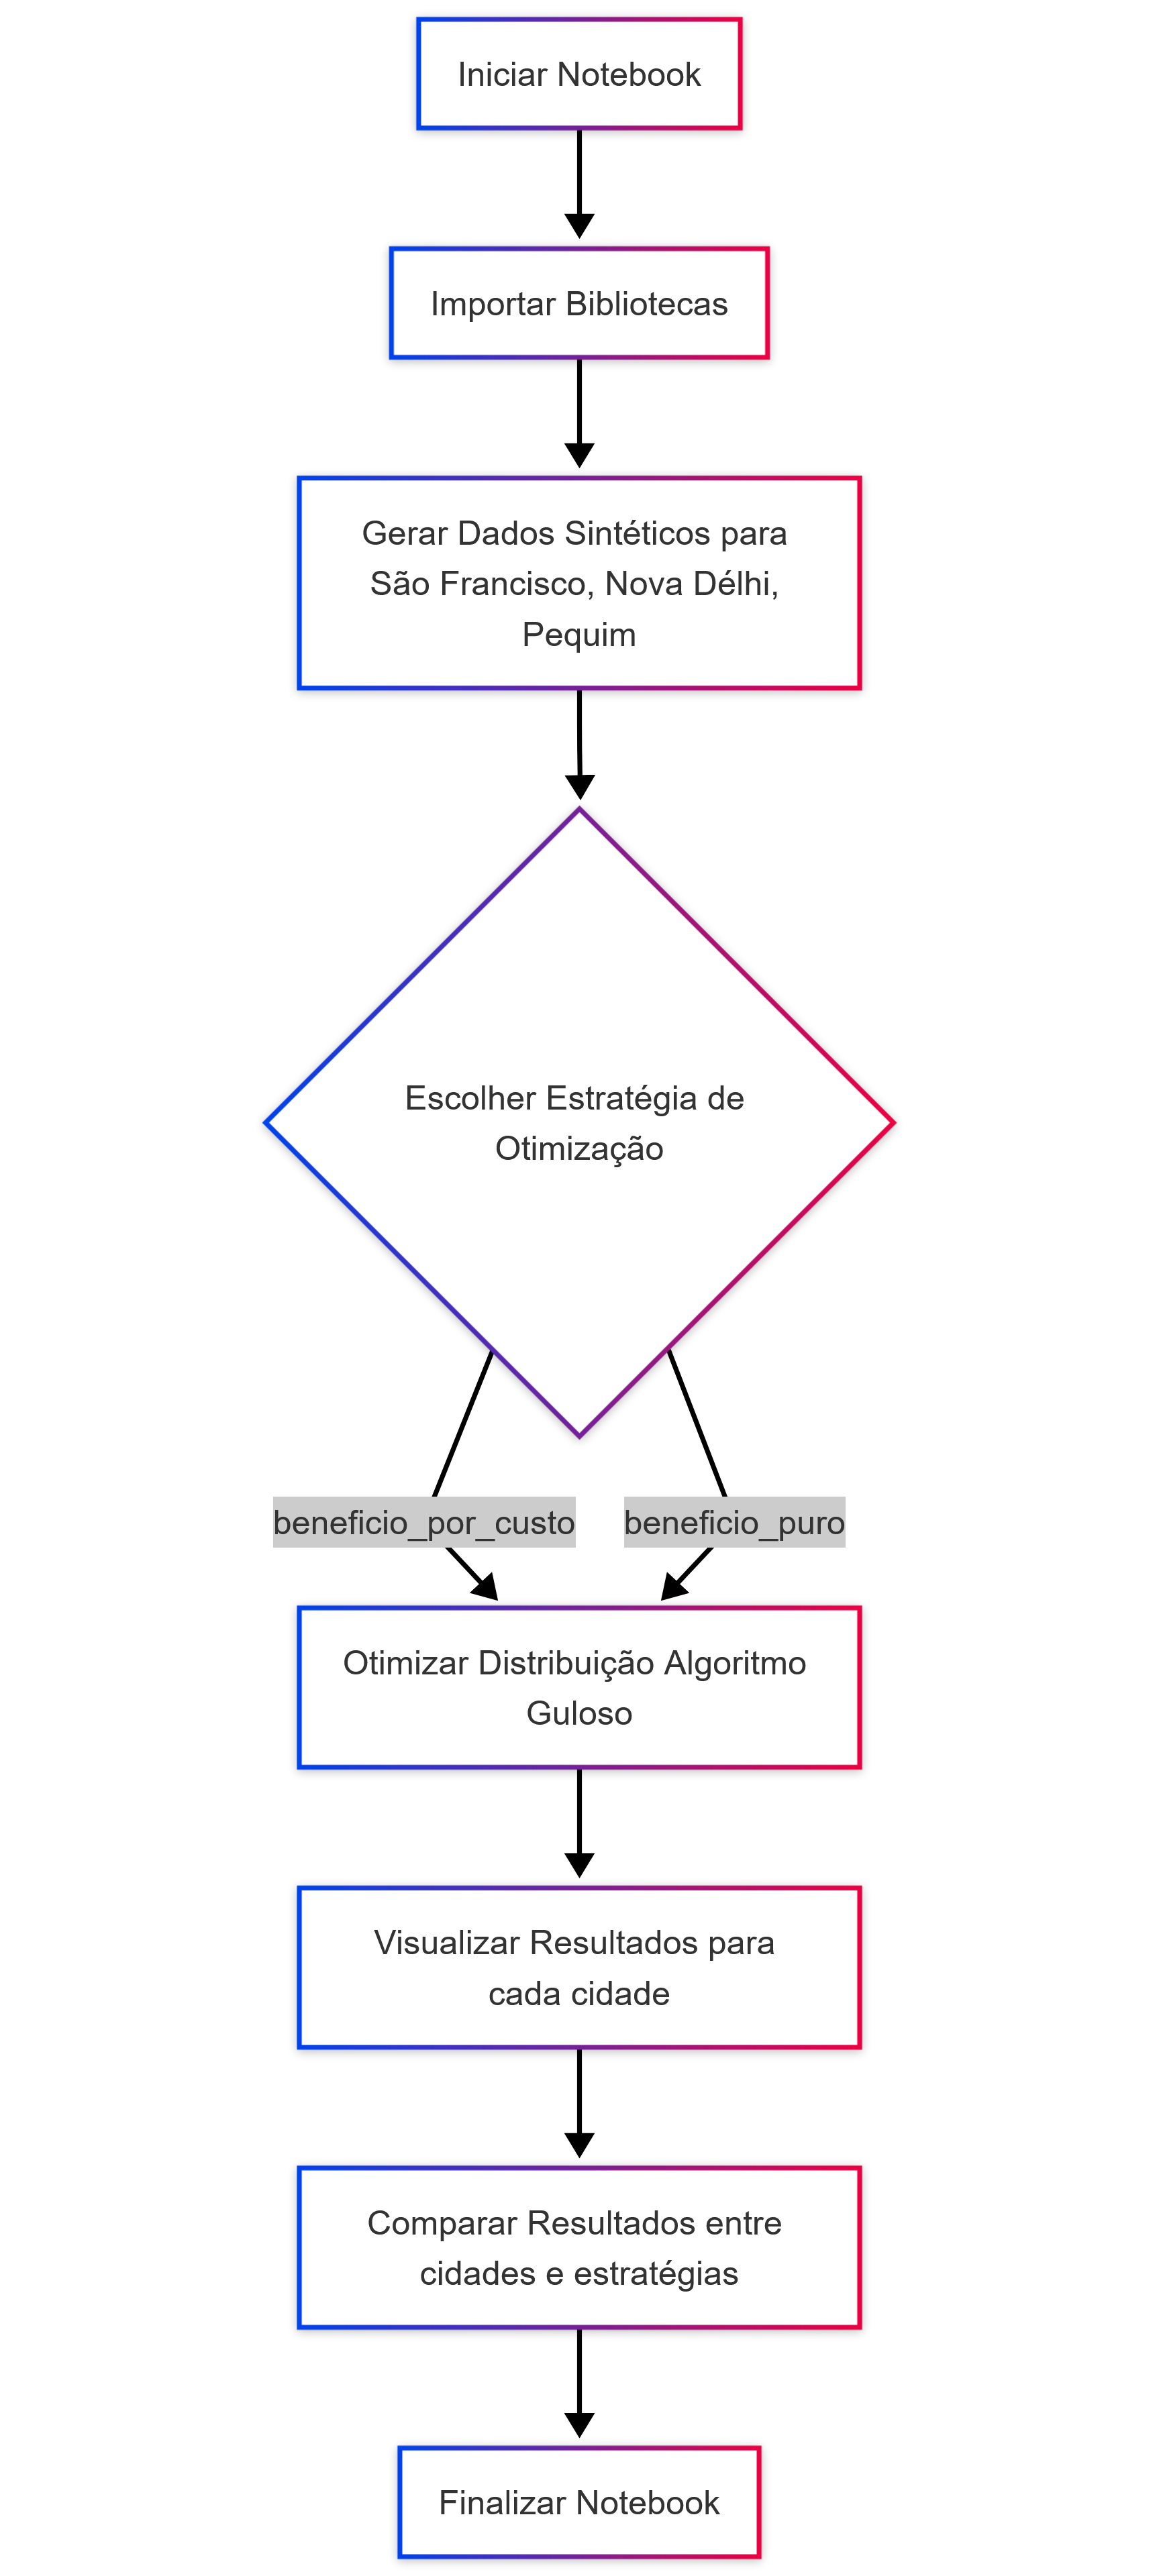

## Objetivos

- Desenvolver um algoritmo guloso para otimizar a distribuição de dois tipos de produtos em ambientes urbanos complexos.
- Maximizar uma função de pontuação que considera cobertura de demanda, sustentabilidade, custos e tempo de entrega.
- Implementar a solução em Python, aplicando boas práticas e técnicas como recursão, memoization, grafos, programação dinâmica (list comprehensions) e `numpy`.
- Simular o problema para três cidades distintas: São Francisco, Nova Délhi e Pequim.
- Visualizar os resultados de forma clara e informativa.
- Analisar as limitações da abordagem gulosa.

## Metodologia e Técnicas

A solução foi desenvolvida utilizando as seguintes técnicas e bibliotecas:

- **Grafos (`networkx`):** Para modelar a estrutura das cidades (ruas, conexões, distâncias).
- **Algoritmo Guloso:** Estratégia principal para tomar decisões locais ótimas na esperança de encontrar uma boa solução global.
- **Filas de Prioridade (`heapq`):** Para selecionar eficientemente a próxima ação (instalação ou entrega) com base no critério guloso.
- **Busca em Largura (BFS com `collections.deque`) e Dijkstra (`networkx`):** Para simular a propagação da cobertura das estações (Produto A) e calcular tempos/rotas de entrega (Produto B) no grafo da cidade.
- **Programação Dinâmica (Conceitos):** Embora o algoritmo principal seja guloso, conceitos como memoization (usando `dict`) podem ser aplicados para otimizar cálculos repetitivos (ex: cálculo de cobertura de uma área, cálculo de rotas).
- **List Comprehensions:** Para escrita de código Python mais conciso e eficiente em operações de lista.
- **NumPy:** Para operações numéricas eficientes, especialmente no cálculo de custos e pontuações.
- **Classes Python:** Para modelar os produtos e suas características específicas.
- **Visualização (`plotly`, `networkx`):** Para apresentar os resultados das simulações de forma gráfica e interativa.
- **Boas Práticas:** Código comentado, nomes de variáveis claros, funções bem definidas.

## 1. Definição das Entradas

Nesta seção, definiremos e simularemos os dados de entrada necessários para o algoritmo. Como dados reais detalhados podem ser difíceis de obter, geraremos dados sintéticos consistentes para cada cidade.

**Estrutura dos Dados de Entrada:**
Para cada cidade, geraremos um dicionário contendo:
- `grafo_cidade`: Um objeto `networkx.Graph` representando a rede de ruas/conexões. Os nós terão atributos `pos` (coordenadas x, y) e as arestas terão um atributo `weight` (distância/tempo).
- `zonas_demanda`: Um dicionário onde as chaves são nós do grafo e os valores representam a intensidade da demanda (ex: 1 a 10) para ambos os produtos nessas zonas prioritárias.
- `locais_instalacao`: Uma lista de nós do grafo que são candidatos a receber uma estação do Produto A ou servir como ponto de partida para o Produto B.
- `custos_por_produto`: Um dicionário com os custos associados:
    - `custo_instalacao_A`: Custo fixo para instalar uma estação do Produto A.
    - `custo_transporte_B_por_unidade_distancia`: Custo variável para entregar o Produto B, dependente da distância.
    - `custo_gerenciamento_A`: Custo de manutenção por estação A.
    - `custo_kit_B`: Custo por kit médico B entregue.
- `orcamento`: O orçamento total disponível para instalação e operação.
- `raio_cobertura_A`: A distância máxima que uma estação do Produto A cobre efetivamente.
- `limite_tempo_entrega_B`: O tempo máximo (em unidades de distância/tempo do grafo) para a entrega do Produto B ser considerada pontual.

In [ ]:
# Importação das bibliotecas necessárias
import numpy as np
import networkx as nx
import heapq
from collections import deque
import random
import math
import plotly.graph_objects as go
import pandas as pd
import tracemalloc
from functools import wraps
import time # Para medir tempo de execução
import itertools # Para gerar IDs únicos
import copy # Para cópias profundas

# Configurações iniciais (ex: seed para reprodutibilidade)
random.seed(42)
np.random.seed(42)

# Contador global para IDs únicos de produtos (reiniciado a cada execução da célula)
id_counter = itertools.count()

In [ ]:
# Lista para armazenar os resultados de memória e tempo
memory_trace = []

def trace_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        start_time = time.time()
        result = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end_time = time.time()
        memory_trace.append({
            "Function": func.__name__,
            "Args": args,
            "Kwargs": kwargs,
            "Result": result,
            "Time (s)": round(end_time - start_time, 6),
            "Current Memory (KB)": round(current / 1024, 3),
            "Peak Memory (KB)": round(peak / 1024, 3)
        })
        return result
    return wrapper

### Função para Geração de Dados Sintéticos da Cidade

In [ ]:
def gerar_dados_cidade(nome_cidade, tamanho_grid=(10, 10), num_nos_adicionais=20, prob_conexao=0.3,
                         percentual_demanda=0.2, percentual_instalacao=0.4,
                         demanda_min=1, demanda_max=10,
                         custo_inst_A_min=100, custo_inst_A_max=500,
                         custo_trans_B_min=1, custo_trans_B_max=5,
                         custo_ger_A_min=10, custo_ger_A_max=50,
                         custo_kit_B_min=20, custo_kit_B_max=100,
                         orcamento_base=10000, fator_orcamento_nos=50,
                         raio_cobertura_A_rel=0.15, limite_tempo_B_rel=0.25):
    """
    Gera dados sintéticos para uma cidade simulada.

    Args:
        nome_cidade (str): Nome da cidade.
        tamanho_grid (tuple): Dimensões para um grafo base em grade (opcional).
        num_nos_adicionais (int): Número de nós aleatórios adicionais para complexidade.
        prob_conexao (float): Probabilidade de conectar nós aleatórios próximos.
        percentual_demanda (float): Percentual de nós que serão zonas de demanda.
        percentual_instalacao (float): Percentual de nós que serão locais de instalação.
        demanda_min/max (int): Range da intensidade de demanda.
        custo_inst_A_min/max (int): Range do custo de instalação do Produto A.
        custo_trans_B_min/max (float): Range do custo de transporte do Produto B por distância.
        custo_ger_A_min/max (int): Range do custo de gerenciamento do Produto A.
        custo_kit_B_min/max (int): Range do custo do kit do Produto B.
        orcamento_base (int): Orçamento base.
        fator_orcamento_nos (int): Fator adicional ao orçamento baseado no número de nós.
        raio_cobertura_A_rel (float): Raio de cobertura relativo à diagonal do espaço.
        limite_tempo_B_rel (float): Limite de tempo relativo à diagonal do espaço.

    Returns:
        dict: Dicionário contendo todos os dados de entrada para a cidade.
    """
    print(f"Gerando dados para {nome_cidade}...")

    # 1. Gerar Grafo da Cidade
    G = nx.Graph()
    pos = {} # Dicionário para armazenar posições dos nós
    max_x, max_y = 0, 0
    start_node_index = 0

    # Adiciona nós da grade (se houver)
    if tamanho_grid and tamanho_grid[0] > 0 and tamanho_grid[1] > 0:
        G_grid = nx.grid_2d_graph(tamanho_grid[0], tamanho_grid[1])
        pos = {node: node for node in G_grid.nodes()}
        G.add_nodes_from(G_grid.nodes(data=True))
        G.add_edges_from(G_grid.edges(data=True))
        max_x, max_y = tamanho_grid[0] - 1, tamanho_grid[1] - 1
        start_node_index = len(G.nodes())
    else:
        # Se não houver grade, define um espaço padrão para nós aleatórios
        max_x, max_y = 10, 10

    # Adiciona nós aleatórios adicionais
    for i in range(num_nos_adicionais):
        node_id = f"rand_{i}" # Usar string para diferenciar de nós da grade
        px, py = random.uniform(0, max_x), random.uniform(0, max_y)
        pos[node_id] = (px, py)
        G.add_node(node_id)

    # Conecta nós aleatórios próximos e nós da grade a nós aleatórios
    all_nodes = list(G.nodes())
    threshold_dist = math.sqrt(max_x**2 + max_y**2) * 0.2 # Limiar de distância para conexão
    for i in range(len(all_nodes)):
        for j in range(i + 1, len(all_nodes)):
            u, v = all_nodes[i], all_nodes[j]
            # Calcula distância euclidiana entre as posições
            dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))

            # Conecta nós se estiverem próximos e com certa probabilidade
            if dist < threshold_dist and dist > 1e-6: # Evita conectar nó a si mesmo se pos for igual
                if random.random() < prob_conexao:
                    if not G.has_edge(u, v):
                        G.add_edge(u, v, weight=dist)

    # Garante que o grafo é conectado (adiciona arestas se necessário)
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if len(components) > 1:
            print(f" -> Grafo inicial não conectado ({len(components)} componentes). Conectando...")
            main_component = components[0]
            for component in components[1:]:
                node_comp = random.choice(list(component))
                node_main = random.choice(list(main_component))
                dist = np.linalg.norm(np.array(pos[node_comp]) - np.array(pos[node_main]))
                G.add_edge(node_comp, node_main, weight=max(dist, 0.1)) # Garante peso positivo

    # Define posições e pesos das arestas (se não definidos)
    nx.set_node_attributes(G, pos, 'pos')
    for u, v, d in G.edges(data=True):
        if 'weight' not in d or d['weight'] <= 0:
             dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
             G[u][v]['weight'] = max(dist, 0.1) # Garante peso positivo

    num_total_nos = len(G.nodes())
    nos_lista = list(G.nodes())

    # 2. Definir Zonas de Demanda
    num_zonas_demanda = max(1, int(num_total_nos * percentual_demanda)) # Garante pelo menos 1
    nos_demanda = random.sample(nos_lista, min(num_zonas_demanda, num_total_nos))
    zonas_demanda = {node: random.randint(demanda_min, demanda_max) for node in nos_demanda}

    # 3. Definir Locais de Instalação
    num_locais_instalacao = max(1, int(num_total_nos * percentual_instalacao)) # Garante pelo menos 1
    locais_instalacao = random.sample(nos_lista, min(num_locais_instalacao, num_total_nos))

    # 4. Definir Custos
    custos_por_produto = {
        'custo_instalacao_A': random.uniform(custo_inst_A_min, custo_inst_A_max),
        'custo_transporte_B_por_unidade_distancia': random.uniform(custo_trans_B_min, custo_trans_B_max),
        'custo_gerenciamento_A': random.uniform(custo_ger_A_min, custo_ger_A_max), # Custo periódico simulado
        'custo_kit_B': random.uniform(custo_kit_B_min, custo_kit_B_max)
    }

    # 5. Definir Orçamento
    orcamento = orcamento_base + num_total_nos * fator_orcamento_nos

    # 6. Definir Raio de Cobertura A e Limite de Tempo B
    diagonal_espaco = np.linalg.norm(np.array([max_x, max_y]) - np.array([0, 0]))
    raio_cobertura_A = max(0.1, diagonal_espaco * raio_cobertura_A_rel) # Garante raio mínimo
    limite_tempo_entrega_B = max(0.1, diagonal_espaco * limite_tempo_B_rel) # Garante tempo mínimo

    print(f' -> Grafo com {num_total_nos} nós e {len(G.edges())} arestas.')
    print(f' -> {len(zonas_demanda)} zonas de demanda.')
    print(f' -> {len(locais_instalacao)} locais potenciais para instalação/entrega.')
    print(f' -> Orçamento: {orcamento:.2f}')
    print(f' -> Raio Cobertura A: {raio_cobertura_A:.2f}')
    print(f' -> Limite Tempo B: {limite_tempo_entrega_B:.2f}')

    return {
        'nome': nome_cidade,
        'grafo_cidade': G,
        'posicoes': pos, # Adiciona posições ao dicionário
        'zonas_demanda': zonas_demanda,
        'locais_instalacao': locais_instalacao,
        'custos_por_produto': custos_por_produto,
        'orcamento': orcamento,
        'raio_cobertura_A': raio_cobertura_A,
        'limite_tempo_entrega_B': limite_tempo_entrega_B
    }

### Geração de Dados para São Francisco (Simulada)

In [ ]:
dados_sf = gerar_dados_cidade(
    nome_cidade='São Francisco',
    tamanho_grid=(12, 8),       # Grade mais retangular
    num_nos_adicionais=30,      # Menos nós aleatórios
    prob_conexao=0.25,          # Conectividade um pouco menor
    percentual_demanda=0.25,    # Demanda concentrada
    percentual_instalacao=0.5,  # Mais locais potenciais
    custo_inst_A_min=150, custo_inst_A_max=600, # Custos potencialmente maiores
    custo_trans_B_min=1.5, custo_trans_B_max=6,
    orcamento_base=12000,
    raio_cobertura_A_rel=0.12, # Raio menor devido à densidade
    limite_tempo_B_rel=0.20    # Tempo de entrega mais restrito
)

Gerando dados para São Francisco...
 -> Grafo inicial não conectado (2 componentes). Conectando...
 -> Grafo com 126 nós e 471 arestas.
 -> 31 zonas de demanda.
 -> 63 locais potenciais para instalação/entrega.
 -> Orçamento: 18300.00
 -> Raio Cobertura A: 1.56
 -> Limite Tempo B: 2.61


### Geração de Dados para Nova Délhi (Simulada)

In [ ]:
dados_delhi = gerar_dados_cidade(
    nome_cidade='Nova Délhi',
    tamanho_grid=(8, 8),        # Grade base menor
    num_nos_adicionais=80,      # Muitos nós aleatórios, alta densidade
    prob_conexao=0.4,           # Maior probabilidade de conexão
    percentual_demanda=0.3,     # Mais áreas de demanda
    percentual_instalacao=0.4,  # Menos locais ideais proporcionalmente
    custo_inst_A_min=80, custo_inst_A_max=400, # Custos potencialmente menores
    custo_trans_B_min=0.8, custo_trans_B_max=4,
    orcamento_base=9000,
    fator_orcamento_nos=40,
    raio_cobertura_A_rel=0.18, # Raio maior para cobrir áreas
    limite_tempo_B_rel=0.30    # Tempo de entrega mais flexível
)

Gerando dados para Nova Délhi...
 -> Grafo com 144 nós e 736 arestas.
 -> 43 zonas de demanda.
 -> 57 locais potenciais para instalação/entrega.
 -> Orçamento: 14760.00
 -> Raio Cobertura A: 1.78
 -> Limite Tempo B: 2.97


### Geração de Dados para Pequim (Simulada)

In [ ]:
dados_beijing = gerar_dados_cidade(
    nome_cidade='Pequim',
    tamanho_grid=(15, 15),      # Grade central maior
    num_nos_adicionais=60,      # Nós aleatórios na periferia
    prob_conexao=0.35,          # Conectividade moderada
    percentual_demanda=0.2,     # Demanda mais distribuída
    percentual_instalacao=0.45,
    custo_inst_A_min=100, custo_inst_A_max=450,
    custo_trans_B_min=1.0, custo_trans_B_max=4.5,
    orcamento_base=15000,       # Orçamento maior para cidade grande
    fator_orcamento_nos=60,
    raio_cobertura_A_rel=0.15,
    limite_tempo_B_rel=0.28
)

Gerando dados para Pequim...
 -> Grafo com 285 nós e 2651 arestas.
 -> 57 zonas de demanda.
 -> 128 locais potenciais para instalação/entrega.
 -> Orçamento: 32100.00
 -> Raio Cobertura A: 2.97
 -> Limite Tempo B: 5.54


## 2. Modelagem dos Produtos

Classes `ProdutoA` e `ProdutoB` para encapsular características e comportamentos.

In [ ]:
class ProdutoA:
    """Representa estações de infraestrutura sustentável (Produto A)."""
    def __init__(self, id_estacao, local, raio_cobertura, custo_instalacao, custo_gerenciamento):
        self.id = id_estacao
        self.local = local
        self.raio_cobertura = raio_cobertura
        self.custo_instalacao = custo_instalacao
        self.custo_gerenciamento = custo_gerenciamento
        self.zonas_cobertas = set()
        self.demanda_atendida = 0

    def calcular_custo_total(self):
        return self.custo_instalacao + self.custo_gerenciamento

    def calcular_cobertura(self, grafo, zonas_demanda, cache_distancias=None):
        # Memoization para distâncias BFS
        if cache_distancias is None:
            cache_distancias = {}
        if self.local not in cache_distancias:
            cache_distancias[self.local] = self._bfs_distancias(grafo, self.local)
        distancias = cache_distancias[self.local]

        self.zonas_cobertas = {no for no, dist in distancias.items() if dist <= self.raio_cobertura}
        self.demanda_atendida = sum(zonas_demanda.get(zona, 0) for zona in self.zonas_cobertas if zona in zonas_demanda)
        return self.zonas_cobertas, self.demanda_atendida

    def _bfs_distancias(self, grafo, origem):
        # BFS otimizado para encontrar nós dentro do raio
        distancias = {origem: 0.0}
        fila = deque([(origem, 0.0)])
        visitados_dist = {origem: 0.0} # Rastreia a menor distância encontrada até agora

        while fila:
            no_atual, dist_atual = fila.popleft()

            # Não precisa explorar além do raio
            if dist_atual > self.raio_cobertura:
                continue

            for vizinho in grafo.neighbors(no_atual):
                peso_aresta = grafo[no_atual][vizinho]['weight']
                nova_dist = dist_atual + peso_aresta

                # Adiciona à fila apenas se estiver dentro do raio e for um caminho melhor
                if nova_dist <= self.raio_cobertura:
                    if vizinho not in visitados_dist or nova_dist < visitados_dist[vizinho]:
                        distancias[vizinho] = nova_dist
                        visitados_dist[vizinho] = nova_dist
                        fila.append((vizinho, nova_dist))
        return distancias

    def __str__(self):
        return f'Estação A-{self.id} @ {self.local} (Cob: {len(self.zonas_cobertas)}, Dem: {self.demanda_atendida})'
    def __repr__(self): return self.__str__()
    def __lt__(self, other): return self.id < other.id # Para heapq
    def __eq__(self, other): return self.id == other.id

In [ ]:
class ProdutoB:
    """Representa kits médicos de emergência (Produto B)."""
    def __init__(self, id_kit, origem, destino, custo_kit, custo_transporte_por_distancia, limite_tempo):
        self.id = id_kit
        self.origem = origem
        self.destino = destino
        self.custo_kit = custo_kit
        self.custo_transporte_por_distancia = custo_transporte_por_distancia
        self.limite_tempo = limite_tempo
        self.distancia = None
        self.tempo_entrega = None
        self.entrega_pontual = None
        self.demanda_atendida = 0
        self.caminho = None

    def calcular_rota_e_tempo(self, grafo, cache_caminhos=None):
        # Memoization para rotas Dijkstra
        if cache_caminhos is None: cache_caminhos = {}
        chave_cache = (self.origem, self.destino)

        if chave_cache in cache_caminhos:
            self.caminho, self.distancia = cache_caminhos[chave_cache]
        else:
            try:
                self.distancia, self.caminho = nx.single_source_dijkstra(grafo, source=self.origem, target=self.destino, weight='weight')
                cache_caminhos[chave_cache] = (self.caminho, self.distancia)
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                self.caminho, self.distancia = None, float('inf')
                cache_caminhos[chave_cache] = (None, float('inf'))

        if self.distancia == float('inf'):
            self.tempo_entrega, self.entrega_pontual = float('inf'), False
        else:
            self.tempo_entrega = self.distancia
            self.entrega_pontual = self.tempo_entrega <= self.limite_tempo

        return self.caminho, self.distancia, self.tempo_entrega, self.entrega_pontual

    def calcular_custo_total(self):
        if self.distancia is None: return float('inf') # Rota não calculada
        if self.distancia == float('inf'): return float('inf') # Rota impossível
        return self.custo_kit + (self.distancia * self.custo_transporte_por_distancia)

    def definir_demanda_atendida(self, zonas_demanda):
        if not self.entrega_pontual or self.distancia == float('inf'):
            self.demanda_atendida = 0
        else:
            self.demanda_atendida = zonas_demanda.get(self.destino, 0)
        return self.demanda_atendida

    def __str__(self):
        status = "Impossível" if self.distancia == float('inf') else ("Pontual" if self.entrega_pontual else "Atrasado")
        dist_str = f'{self.distancia:.2f}' if self.distancia != float('inf') else 'inf'
        return f'Kit B-{self.id} {self.origem}->{self.destino} (Dist: {dist_str}, Stat: {status}, Dem: {self.demanda_atendida})'
    def __repr__(self): return self.__str__()
    def __lt__(self, other): return self.id < other.id # Para heapq
    def __eq__(self, other): return self.id == other.id

### Funções Auxiliares para Criação de Produtos

In [ ]:
def criar_estacao_A(id_estacao, local, dados_cidade):
    return ProdutoA(
        id_estacao=id_estacao,
        local=local,
        raio_cobertura=dados_cidade['raio_cobertura_A'],
        custo_instalacao=dados_cidade['custos_por_produto']['custo_instalacao_A'],
        custo_gerenciamento=dados_cidade['custos_por_produto']['custo_gerenciamento_A']
    )

def criar_kit_B(id_kit, origem, destino, dados_cidade):
    return ProdutoB(
        id_kit=id_kit,
        origem=origem,
        destino=destino,
        custo_kit=dados_cidade['custos_por_produto']['custo_kit_B'],
        custo_transporte_por_distancia=dados_cidade['custos_por_produto']['custo_transporte_B_por_unidade_distancia'],
        limite_tempo=dados_cidade['limite_tempo_entrega_B']
    )

## 3. Função de Pontuação Composta

Função para avaliar a qualidade das soluções com base em cobertura, sustentabilidade e custo.

In [ ]:
def calcular_pontuacao_composta(estacoes_A, kits_B, dados_cidade, pesos=None):
    """Calcula a pontuação composta para uma solução."""
    if pesos is None:
        pesos = {'cobertura': 0.5, 'sustentabilidade': 0.3, 'custo': -0.2}

    # 1. Cobertura de Demanda
    zonas_demanda = dados_cidade['zonas_demanda']
    demanda_total = sum(zonas_demanda.values())
    if demanda_total == 0: return 0.0, {} # Evita divisão por zero

    zonas_cobertas_A = set().union(*(est.zonas_cobertas for est in estacoes_A))
    zonas_atendidas_B = {kit.destino for kit in kits_B if kit.entrega_pontual and kit.destino in zonas_demanda}
    zonas_atendidas_total = zonas_cobertas_A.union(zonas_atendidas_B)
    demanda_atendida_total_unica = sum(zonas_demanda.get(zona, 0) for zona in zonas_atendidas_total if zona in zonas_demanda)
    proporcao_demanda_atendida = demanda_atendida_total_unica / demanda_total

    # 2. Sustentabilidade
    num_locais_instalacao = len(dados_cidade['locais_instalacao'])
    num_zonas_demanda = len(zonas_demanda)
    denominador_A = max(1, num_locais_instalacao * 0.5) # Normalizador A
    proporcao_estacoes_A = min(1.0, len(estacoes_A) / denominador_A)
    kits_pontuais = [kit for kit in kits_B if kit.entrega_pontual]
    denominador_B = max(1, num_zonas_demanda) # Normalizador B
    proporcao_kits_pontuais = min(1.0, len(kits_pontuais) / denominador_B)
    indice_sustentabilidade = 0.5 * proporcao_estacoes_A + 0.5 * proporcao_kits_pontuais

    # 3. Custo
    custo_total_A = sum(est.calcular_custo_total() for est in estacoes_A)
    custo_total_B = sum(kit.calcular_custo_total() for kit in kits_B if kit.distancia != float('inf'))
    custo_total = custo_total_A + custo_total_B
    orcamento_total = dados_cidade['orcamento']
    custo_normalizado = min(1.0, custo_total / orcamento_total) if orcamento_total > 0 else (1.0 if custo_total > 0 else 0.0)

    # 4. Pontuação Final
    pontuacao_cobertura = pesos['cobertura'] * proporcao_demanda_atendida
    pontuacao_sustentabilidade = pesos['sustentabilidade'] * indice_sustentabilidade
    pontuacao_custo = pesos['custo'] * custo_normalizado
    pontuacao_total = pontuacao_cobertura + pontuacao_sustentabilidade + pontuacao_custo

    detalhes = {
        'pontuacao_total': pontuacao_total, 'pontuacao_cobertura': pontuacao_cobertura,
        'pontuacao_sustentabilidade': pontuacao_sustentabilidade, 'pontuacao_custo': pontuacao_custo,
        'proporcao_demanda_atendida': proporcao_demanda_atendida, 'indice_sustentabilidade': indice_sustentabilidade,
        'custo_normalizado': custo_normalizado, 'custo_total': custo_total, 'custo_total_A': custo_total_A, 'custo_total_B': custo_total_B,
        'num_estacoes_A': len(estacoes_A), 'num_kits_B': len(kits_B), 'num_kits_pontuais': len(kits_pontuais),
        'demanda_atendida_total_unica': demanda_atendida_total_unica, 'demanda_total': demanda_total
    }
    return pontuacao_total, detalhes

## 4. Estratégias Gulosas

Vamos propor e comparar duas estratégias gulosas para resolver o problema de otimização.

In [ ]:
def calcular_beneficio_por_custo_A(estacao, grafo, zonas_demanda, cache_distancias=None):
    """Calcula a relação benefício/custo para uma estação do Produto A."""
    zonas_cobertas, demanda_atendida = estacao.calcular_cobertura(grafo, zonas_demanda, cache_distancias)
    custo = estacao.calcular_custo_total()
    if custo <= 0: return 0.0
    return demanda_atendida / custo

def calcular_beneficio_por_custo_B(kit, grafo, zonas_demanda, cache_caminhos=None):
    """Calcula a relação benefício/custo para um kit do Produto B."""
    caminho, distancia, tempo, pontual = kit.calcular_rota_e_tempo(grafo, cache_caminhos)
    if not pontual: return 0.0
    demanda_atendida = kit.definir_demanda_atendida(zonas_demanda)
    custo = kit.calcular_custo_total()
    if custo <= 0 or custo == float('inf'): return 0.0
    return demanda_atendida / custo

def calcular_beneficio_puro_A(estacao, grafo, zonas_demanda, cache_distancias=None):
    """Calcula o benefício puro (demanda atendida) para uma estação do Produto A."""
    zonas_cobertas, demanda_atendida = estacao.calcular_cobertura(grafo, zonas_demanda, cache_distancias)
    return demanda_atendida

def calcular_beneficio_puro_B(kit, grafo, zonas_demanda, cache_caminhos=None):
    """Calcula o benefício puro (demanda atendida) para um kit do Produto B."""
    caminho, distancia, tempo, pontual = kit.calcular_rota_e_tempo(grafo, cache_caminhos)
    if not pontual: return 0.0
    demanda_atendida = kit.definir_demanda_atendida(zonas_demanda)
    return demanda_atendida

### Comparação das Estratégias Gulosas

Vamos comparar duas estratégias gulosas para a seleção de produtos:

1. **Estratégia de Benefício por Custo**: Seleciona produtos com base na relação benefício/custo (demanda atendida por unidade de custo).
2. **Estratégia de Benefício Puro**: Seleciona produtos com base apenas no benefício (demanda atendida), ignorando o custo.

#### Estratégia 1: Benefício por Custo
- **Vantagens**: Maximiza a eficiência do orçamento, priorizando produtos que oferecem maior retorno por unidade monetária investida.
- **Desvantagens**: Pode ignorar áreas de alta demanda se o custo for muito alto, mesmo que essas áreas sejam críticas.

#### Estratégia 2: Benefício Puro
- **Vantagens**: Prioriza áreas de alta demanda, independentemente do custo, garantindo cobertura das regiões mais necessitadas.
- **Desvantagens**: Pode esgotar rapidamente o orçamento em poucas instalações/entregas de alto custo, deixando muitas áreas sem atendimento.

#### Justificativa da Escolha
Para este problema, a **Estratégia de Benefício por Custo** é mais adequada uma vez que:
1. Estamos trabalhando com orçamento limitado, tornando a eficiência financeira crucial.
2. Queremos maximizar a cobertura total, o que é melhor alcançado distribuindo recursos de forma eficiente.
3. A função de pontuação composta já considera tanto a cobertura quanto o custo, alinhando-se com esta estratégia.
4. Em cenários urbanos reais, a relação custo-benefício é frequentemente um fator decisivo na alocação de recursos públicos.

No entanto, implementaremos ambas as estratégias para comparação e demonstração.

## 5. Pseudocódigo e Análise de Complexidade

### Pseudocódigo do Algoritmo Guloso (Estratégia de Benefício por Custo)

```
função OTIMIZAR_DISTRIBUIÇÃO(grafo_cidade, zonas_demanda, locais_instalacao, custos, orçamento, raio_cobertura_A, limite_tempo_B):
    # Inicialização
    estacoes_A_selecionadas ← []
    kits_B_selecionados ← []
    orçamento_restante ← orçamento
    zonas_cobertas ← {}
    cache_distancias ← {}
    cache_caminhos ← {}
    
    # Gerar todos os candidatos possíveis
    candidatos_A ← []
    para cada local em locais_instalacao:
        estacao ← CRIAR_ESTAÇÃO_A(local, raio_cobertura_A, custos)
        beneficio_custo ← CALCULAR_BENEFÍCIO_POR_CUSTO_A(estacao, grafo_cidade, zonas_demanda, cache_distancias)
        se beneficio_custo > 0:
            adicionar (estacao, beneficio_custo) a candidatos_A
    
    candidatos_B ← []
    para cada origem em locais_instalacao:
        para cada destino em zonas_demanda:
            kit ← CRIAR_KIT_B(origem, destino, limite_tempo_B, custos)
            beneficio_custo ← CALCULAR_BENEFÍCIO_POR_CUSTO_B(kit, grafo_cidade, zonas_demanda, cache_caminhos)
            se beneficio_custo > 0:
                adicionar (kit, beneficio_custo) a candidatos_B
    
    # Ordenar candidatos por benefício/custo (decrescente)
    ordenar candidatos_A por beneficio_custo em ordem decrescente
    ordenar candidatos_B por beneficio_custo em ordem decrescente
    
    # Selecionar produtos gulosos até esgotar orçamento
    todos_candidatos ← mesclar candidatos_A e candidatos_B, ordenados por beneficio_custo
    
    para cada (produto, beneficio_custo) em todos_candidatos:
        custo_produto ← produto.calcular_custo_total()
        
        se custo_produto <= orçamento_restante:
            se produto é do tipo ProdutoA:
                adicionar produto a estacoes_A_selecionadas
                atualizar zonas_cobertas com produto.zonas_cobertas
            senão: # produto é do tipo ProdutoB
                # Verificar se o destino já está coberto por estações A
                se produto.destino não está em zonas_cobertas:
                    adicionar produto a kits_B_selecionados
                    adicionar produto.destino a zonas_cobertas
            
            orçamento_restante ← orçamento_restante - custo_produto
    
    # Recalcular cobertura final (para garantir consistência)
    para cada estacao em estacoes_A_selecionadas:
        estacao.calcular_cobertura(grafo_cidade, zonas_demanda, cache_distancias)
    
    para cada kit em kits_B_selecionados:
        kit.calcular_rota_e_tempo(grafo_cidade, cache_caminhos)
        kit.definir_demanda_atendida(zonas_demanda)
    
    retornar estacoes_A_selecionadas, kits_B_selecionados, orçamento_restante
```

### Análise de Complexidade

#### Complexidade de Tempo

Seja:
- n = número de nós no grafo
- m = número de arestas no grafo
- l = número de locais de instalação
- z = número de zonas de demanda

1. **Geração de Candidatos**:
   - Candidatos A: O(l)
     - Para cada local, calculamos a cobertura usando BFS: O(m + n)
     - Total para candidatos A: O(l * (m + n))
   - Candidatos B: O(l * z)
     - Para cada par origem-destino, calculamos o caminho usando Dijkstra: O(m + n log n)
     - Total para candidatos B: O(l * z * (m + n log n))

2. **Ordenação de Candidatos**:
   - Candidatos A: O(l log l)
   - Candidatos B: O(l * z * log(l * z))

3. **Seleção Gulosa**:
   - Mesclar listas ordenadas: O(l + l*z)
   - Iterar sobre candidatos: O(l + l*z)

4. **Recálculo Final**:
   - No pior caso, todos os candidatos são selecionados: O(l * (m + n) + l * z * (m + n log n))

**Complexidade Total**: O(l * z * (m + n log n))

A etapa dominante é o cálculo de caminhos para os kits B usando Dijkstra, especialmente quando temos muitos locais de instalação e zonas de demanda.

#### Complexidade de Espaço

1. **Grafo**: O(n + m)
2. **Caches**:
   - Cache de distâncias: O(l * n) no pior caso
   - Cache de caminhos: O(l * z * n) no pior caso
3. **Candidatos**: O(l + l*z)
4. **Produtos selecionados**: O(l + l*z) no pior caso

**Complexidade Total de Espaço**: O(l * z * n + m)

A memoization dos caminhos e distâncias é o fator dominante no uso de memória, mas é essencial para evitar recálculos repetitivos e melhorar significativamente o desempenho.

## 6. Implementação

Vamos implementar o algoritmo guloso conforme o pseudocódigo, utilizando as estruturas recomendadas.

In [ ]:
@trace_memory
def otimizar_distribuicao(dados_cidade, estrategia='beneficio_por_custo'):
    """Implementa o algoritmo guloso para otimização da distribuição de produtos.

    Args:
        dados_cidade: Dicionário com dados da cidade
        estrategia: 'beneficio_por_custo' ou 'beneficio_puro'

    Returns:
        Tupla (estacoes_A, kits_B, orcamento_restante, detalhes_pontuacao)
    """
    print(f"Otimizando distribuição para {dados_cidade['nome']} usando estratégia: {estrategia}")

    # Extrair dados
    grafo = dados_cidade['grafo_cidade']
    zonas_demanda = dados_cidade['zonas_demanda']
    locais_instalacao = dados_cidade['locais_instalacao']
    orcamento = dados_cidade['orcamento']
    raio_cobertura_A = dados_cidade['raio_cobertura_A']
    limite_tempo_B = dados_cidade['limite_tempo_entrega_B']

    # Inicialização
    estacoes_A = []
    kits_B = []
    orcamento_restante = orcamento
    zonas_cobertas = set()
    cache_distancias = {}
    cache_caminhos = {}

    # Resetar contador de IDs
    global id_counter
    id_counter = itertools.count()

    # Gerar candidatos A (estações)
    print(f" -> Gerando candidatos para estações (Produto A)...")
    candidatos_A = []
    for local in locais_instalacao:
        estacao = criar_estacao_A(next(id_counter), local, dados_cidade)

        # Calcular benefício conforme estratégia
        if estrategia == 'beneficio_por_custo':
            beneficio = calcular_beneficio_por_custo_A(estacao, grafo, zonas_demanda, cache_distancias)
        else: # beneficio_puro
            beneficio = calcular_beneficio_puro_A(estacao, grafo, zonas_demanda, cache_distancias)

        if beneficio > 0:
            candidatos_A.append((estacao, beneficio))

    # Gerar candidatos B (kits)
    print(f" -> Gerando candidatos para kits (Produto B)...")
    candidatos_B = []
    for origem in locais_instalacao:
        for destino in zonas_demanda.keys():
            if origem != destino:  # Evitar origem = destino
                kit = criar_kit_B(next(id_counter), origem, destino, dados_cidade)

                # Calcular benefício conforme estratégia
                if estrategia == 'beneficio_por_custo':
                    beneficio = calcular_beneficio_por_custo_B(kit, grafo, zonas_demanda, cache_caminhos)
                else: # beneficio_puro
                    beneficio = calcular_beneficio_puro_B(kit, grafo, zonas_demanda, cache_caminhos)

                if beneficio > 0:
                    candidatos_B.append((kit, beneficio))

    # Ordenar candidatos por benefício (decrescente)
    candidatos_A.sort(key=lambda x: x[1], reverse=True)
    candidatos_B.sort(key=lambda x: x[1], reverse=True)

    print(f" -> {len(candidatos_A)} candidatos A e {len(candidatos_B)} candidatos B gerados.")

    # Mesclar candidatos (mantendo ordenação por benefício)
    # Usamos heapq.merge para mesclar listas ordenadas eficientemente
    # Invertemos o benefício para usar com heapq (que é min-heap)
    candidatos_A_inv = [(-b, a) for a, b in candidatos_A]
    candidatos_B_inv = [(-b, a) for a, b in candidatos_B]

    # Mesclar usando heapq.merge (mantém ordenação)
    todos_candidatos_inv = list(heapq.merge(candidatos_A_inv, candidatos_B_inv))
    # Converter de volta para (produto, beneficio)
    todos_candidatos = [(p, -b) for b, p in todos_candidatos_inv]

    # Seleção gulosa
    print(f" -> Selecionando produtos gulosos (orçamento: {orcamento_restante:.2f})...")
    for produto, beneficio in todos_candidatos:
        custo = produto.calcular_custo_total()

        if custo <= orcamento_restante:
            if isinstance(produto, ProdutoA):
                # Verificar se vale a pena adicionar esta estação
                # (pode ser que todas as zonas que ela cobre já estejam cobertas)
                zonas_novas = produto.zonas_cobertas - zonas_cobertas
                if zonas_novas:
                    estacoes_A.append(produto)
                    zonas_cobertas.update(produto.zonas_cobertas)
                    orcamento_restante -= custo
                    print(f"   + Adicionada estação A-{produto.id} @ {produto.local} (custo: {custo:.2f}, restante: {orcamento_restante:.2f})")
            else: # ProdutoB
                # Verificar se o destino já está coberto por estações A
                if produto.destino not in zonas_cobertas and produto.entrega_pontual:
                    kits_B.append(produto)
                    zonas_cobertas.add(produto.destino)
                    orcamento_restante -= custo
                    print(f"   + Adicionado kit B-{produto.id} {produto.origem}->{produto.destino} (custo: {custo:.2f}, restante: {orcamento_restante:.2f})")

    # Recalcular cobertura final (para garantir consistência)
    for estacao in estacoes_A:
        estacao.calcular_cobertura(grafo, zonas_demanda, cache_distancias)

    for kit in kits_B:
        kit.calcular_rota_e_tempo(grafo, cache_caminhos)
        kit.definir_demanda_atendida(zonas_demanda)

    # Calcular pontuação final
    pontuacao, detalhes = calcular_pontuacao_composta(estacoes_A, kits_B, dados_cidade)

    print(f" -> Seleção concluída: {len(estacoes_A)} estações A, {len(kits_B)} kits B")
    print(f" -> Orçamento restante: {orcamento_restante:.2f} de {orcamento:.2f} ({orcamento_restante/orcamento*100:.1f}%)")
    print(f" -> Pontuação final: {pontuacao:.4f}")

    return estacoes_A, kits_B, orcamento_restante, detalhes

In [ ]:
def visualizar_resultados(dados_cidade, estacoes_A, kits_B, detalhes):
    """Visualiza os resultados da otimização usando plotly e networkx."""
    G = dados_cidade['grafo_cidade']
    pos = dados_cidade['posicoes']
    zonas_demanda = dados_cidade['zonas_demanda']

    # Preparar dados para visualização
    node_x, node_y = [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    # Criar traço para nós
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            size=10,
            color=[],
            line_width=2))

    # Criar traço para arestas
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Colorir nós conforme seu papel
    node_colors = []
    node_sizes = []
    node_text = []

    estacoes_locais = {est.local for est in estacoes_A}
    kits_destinos = {kit.destino for kit in kits_B}
    kits_origens = {kit.origem for kit in kits_B}

    for node in G.nodes():
        if node in zonas_demanda:
            if node in estacoes_locais:
                color = 'red'  # Estação A em zona de demanda
                size = 15
                text = f"Nó {node}: Zona de demanda ({zonas_demanda[node]}) com Estação A"
            elif node in kits_destinos:
                color = 'orange'  # Destino de Kit B
                size = 13
                text = f"Nó {node}: Zona de demanda ({zonas_demanda[node]}) com Kit B"
            else:
                color = 'black'  # Zona de demanda não atendida
                size = 10
                text = f"Nó {node}: Zona de demanda ({zonas_demanda[node]}) não atendida"
        elif node in estacoes_locais:
            color = 'blue'  # Estação A fora de zona de demanda
            size = 15
            text = f"Nó {node}: Estação A"
        elif node in kits_origens:
            color = 'green'  # Origem de Kit B
            size = 13
            text = f"Nó {node}: Origem de Kit B"
        else:
            color = 'gray'  # Nó regular
            size = 8
            text = f"Nó {node}"

        node_colors.append(color)
        node_sizes.append(size)
        node_text.append(text)

    node_trace.marker.color = node_colors
    node_trace.marker.size = node_sizes
    node_trace.text = node_text

    # Criar traços para caminhos dos kits B
    path_traces = []
    for kit in kits_B:
        if kit.caminho and len(kit.caminho) > 1:
            path_x, path_y = [], []
            for node in kit.caminho:
                x, y = pos[node]
                path_x.append(x)
                path_y.append(y)

            path_trace = go.Scatter(
                x=path_x, y=path_y,
                line=dict(width=2, color='purple'),
                hoverinfo='text',
                text=f"Caminho Kit B-{kit.id}: {kit.origem} -> {kit.destino}",
                mode='lines')

            path_traces.append(path_trace)

    # Criar traços para raios de cobertura das estações A
    coverage_traces = []
    for estacao in estacoes_A:
        x, y = pos[estacao.local]

        # Criar círculo para raio de cobertura
        theta = np.linspace(0, 2*np.pi, 100)
        circle_x = x + estacao.raio_cobertura * np.cos(theta)
        circle_y = y + estacao.raio_cobertura * np.sin(theta)

        coverage_trace = go.Scatter(
            x=circle_x, y=circle_y,
            line=dict(width=1, color='rgba(0, 0, 255, 0.2)'),
            fill='toself',
            fillcolor='rgba(0, 0, 255, 0.1)',
            hoverinfo='text',
            text=f"Cobertura Estação A-{estacao.id} @ {estacao.local}",
            mode='lines')

        coverage_traces.append(coverage_trace)

    # Criar figura
    fig = go.Figure(data=[edge_trace] + coverage_traces + path_traces + [node_trace],
                   layout=go.Layout(
                       title=f'Otimização para {dados_cidade["nome"]} - Pontuação: {detalhes["pontuacao_total"]:.4f}',
                       titlefont_size=16,
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=20, l=5, r=5, t=40),
                       xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       width=800,
                       height=600,
                       plot_bgcolor='white'
                   ))

    # Adicionar anotações para estatísticas
    stats_text = f"""Estações A: {len(estacoes_A)}<br>
Kits B: {len(kits_B)}<br>
Demanda Atendida: {detalhes['demanda_atendida_total_unica']}/{detalhes['demanda_total']} ({detalhes['proporcao_demanda_atendida']*100:.1f}%)<br>
Custo Total: {detalhes['custo_total']:.2f}<br>
Orçamento: {dados_cidade['orcamento']:.2f}"""

    fig.add_annotation(
        x=0.02, y=0.02,
        xref="paper", yref="paper",
        text=stats_text,
        showarrow=False,
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        borderpad=4,
        align="left"
    )

    # Adicionar legenda
    legend_text = """<b>Legenda:</b><br>
● Azul: Estação A<br>
● Vermelho: Estação A em zona de demanda<br>
● Verde: Origem de Kit B<br>
● Laranja: Destino de Kit B<br>
● Preto: Zona de demanda não atendida<br>
● Cinza: Nó regular<br>
— Roxo: Caminho de entrega Kit B<br>
◌ Azul claro: Raio de cobertura Estação A"""

    fig.add_annotation(
        x=0.98, y=0.98,
        xref="paper", yref="paper",
        text=legend_text,
        showarrow=False,
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        borderpad=4,
        align="right"
    )

    return fig

## 7. Simulação e Visualização

Vamos aplicar o algoritmo guloso para cada uma das cidades simuladas e visualizar os resultados.

In [ ]:
# Simulação para São Francisco
print("\n" + "="*80)
print("SIMULAÇÃO PARA SÃO FRANCISCO")
print("="*80)

estacoes_sf_A, kits_sf_B, orcamento_sf_restante, detalhes_sf = otimizar_distribuicao(dados_sf, estrategia='beneficio_por_custo')

# Visualizar resultados
fig_sf = visualizar_resultados(dados_sf, estacoes_sf_A, kits_sf_B, detalhes_sf)
fig_sf.show()


SIMULAÇÃO PARA SÃO FRANCISCO
Otimizando distribuição para São Francisco usando estratégia: beneficio_por_custo
 -> Gerando candidatos para estações (Produto A)...
 -> Gerando candidatos para kits (Produto B)...
 -> 45 candidatos A e 243 candidatos B gerados.
 -> Selecionando produtos gulosos (orçamento: 18300.00)...
   + Adicionado kit B-1655 rand_6->rand_23 (custo: 64.53, restante: 18235.47)
   + Adicionado kit B-747 (6, 2)->(6, 3) (custo: 64.59, restante: 18170.88)
   + Adicionado kit B-1214 (11, 1)->(11, 0) (custo: 64.59, restante: 18106.30)
   + Adicionado kit B-1099 rand_23->(1, 2) (custo: 60.15, restante: 18046.15)
   + Adicionado kit B-1328 (4, 4)->rand_17 (custo: 60.60, restante: 17985.55)
   + Adicionado kit B-1579 rand_14->rand_18 (custo: 60.66, restante: 17924.89)
   + Adicionado kit B-1595 rand_14->(9, 5) (custo: 63.77, restante: 17861.13)
   + Adicionado kit B-844 (4, 3)->(5, 3) (custo: 64.59, restante: 17796.54)
   + Adicionado kit B-357 (9, 5)->rand_14 (custo: 63.77, re

In [ ]:
# Simulação para Nova Délhi
print("\n" + "="*80)
print("SIMULAÇÃO PARA NOVA DÉLHI")
print("="*80)

estacoes_delhi_A, kits_delhi_B, orcamento_delhi_restante, detalhes_delhi = otimizar_distribuicao(dados_delhi, estrategia='beneficio_por_custo')

# Visualizar resultados
fig_delhi = visualizar_resultados(dados_delhi, estacoes_delhi_A, kits_delhi_B, detalhes_delhi)
fig_delhi.show()


SIMULAÇÃO PARA NOVA DÉLHI
Otimizando distribuição para Nova Délhi usando estratégia: beneficio_por_custo
 -> Gerando candidatos para estações (Produto A)...
 -> Gerando candidatos para kits (Produto B)...
 -> 57 candidatos A e 746 candidatos B gerados.
 -> Selecionando produtos gulosos (orçamento: 14760.00)...
   + Adicionada estação A-30 @ rand_77 (custo: 364.59, restante: 14395.41)
   + Adicionada estação A-53 @ rand_58 (custo: 364.59, restante: 14030.83)
   + Adicionada estação A-34 @ rand_19 (custo: 364.59, restante: 13666.24)
   + Adicionada estação A-14 @ rand_76 (custo: 364.59, restante: 13301.65)
   + Adicionada estação A-16 @ rand_32 (custo: 364.59, restante: 12937.06)
   + Adicionada estação A-5 @ rand_62 (custo: 364.59, restante: 12572.48)
   + Adicionada estação A-38 @ (6, 4) (custo: 364.59, restante: 12207.89)
   + Adicionada estação A-26 @ (1, 3) (custo: 364.59, restante: 11843.30)
   + Adicionada estação A-44 @ rand_13 (custo: 364.59, restante: 11478.71)
   + Adicionada

In [ ]:
# Simulação para Pequim
print("\n" + "="*80)
print("SIMULAÇÃO PARA PEQUIM")
print("="*80)

estacoes_beijing_A, kits_beijing_B, orcamento_beijing_restante, detalhes_beijing = otimizar_distribuicao(dados_beijing, estrategia='beneficio_por_custo')

# Visualizar resultados
fig_beijing = visualizar_resultados(dados_beijing, estacoes_beijing_A, kits_beijing_B, detalhes_beijing)
fig_beijing.show()


SIMULAÇÃO PARA PEQUIM
Otimizando distribuição para Pequim usando estratégia: beneficio_por_custo
 -> Gerando candidatos para estações (Produto A)...
 -> Gerando candidatos para kits (Produto B)...
 -> 127 candidatos A e 2236 candidatos B gerados.
 -> Selecionando produtos gulosos (orçamento: 32100.00)...
   + Adicionada estação A-4 @ rand_27 (custo: 395.94, restante: 31704.06)
   + Adicionada estação A-79 @ (10, 4) (custo: 395.94, restante: 31308.11)
   + Adicionada estação A-90 @ (12, 3) (custo: 395.94, restante: 30912.17)
   + Adicionada estação A-65 @ (6, 5) (custo: 395.94, restante: 30516.23)
   + Adicionada estação A-51 @ (9, 5) (custo: 395.94, restante: 30120.29)
   + Adicionada estação A-48 @ (2, 5) (custo: 395.94, restante: 29724.34)
   + Adicionada estação A-126 @ (7, 4) (custo: 395.94, restante: 29328.40)
   + Adicionada estação A-14 @ (9, 2) (custo: 395.94, restante: 28932.46)
   + Adicionada estação A-56 @ rand_56 (custo: 395.94, restante: 28536.52)
   + Adicionada estação

### Comparação das Estratégias Gulosas

Vamos comparar as duas estratégias (benefício por custo vs. benefício puro) para São Francisco.

In [ ]:
# Comparação de estratégias para São Francisco
print("\n" + "="*80)
print("COMPARAÇÃO DE ESTRATÉGIAS PARA SÃO FRANCISCO")
print("="*80)

# Estratégia de benefício puro
print("\nESTRATÉGIA: BENEFÍCIO PURO")
estacoes_sf_A_puro, kits_sf_B_puro, orcamento_sf_restante_puro, detalhes_sf_puro = otimizar_distribuicao(dados_sf, estrategia='beneficio_puro')

# Visualizar resultados
fig_sf_puro = visualizar_resultados(dados_sf, estacoes_sf_A_puro, kits_sf_B_puro, detalhes_sf_puro)
fig_sf_puro.show()


COMPARAÇÃO DE ESTRATÉGIAS PARA SÃO FRANCISCO

ESTRATÉGIA: BENEFÍCIO PURO
Otimizando distribuição para São Francisco usando estratégia: beneficio_puro
 -> Gerando candidatos para estações (Produto A)...
 -> Gerando candidatos para kits (Produto B)...
 -> 45 candidatos A e 243 candidatos B gerados.
 -> Selecionando produtos gulosos (orçamento: 18300.00)...
   + Adicionada estação A-9 @ (9, 5) (custo: 612.78, restante: 17687.22)
   + Adicionada estação A-33 @ rand_23 (custo: 612.78, restante: 17074.44)
   + Adicionada estação A-51 @ rand_6 (custo: 612.78, restante: 16461.66)
   + Adicionada estação A-49 @ rand_14 (custo: 612.78, restante: 15848.88)
   + Adicionada estação A-22 @ (6, 2) (custo: 612.78, restante: 15236.10)
   + Adicionada estação A-17 @ (1, 1) (custo: 612.78, restante: 14623.33)
   + Adicionada estação A-50 @ (1, 3) (custo: 612.78, restante: 14010.55)
   + Adicionada estação A-25 @ (4, 3) (custo: 612.78, restante: 13397.77)
   + Adicionada estação A-54 @ (8, 6) (custo: 612

In [ ]:
# Criar DataFrame para comparação de resultados
resultados_comparacao = [
    {
        "Cidade": "São Francisco",
        "Estratégia": "Benefício por Custo",
        "Pontuação": detalhes_sf['pontuacao_total'],
        "Demanda Atendida (%)": detalhes_sf['proporcao_demanda_atendida']*100,
        "Custo Total": detalhes_sf['custo_total'],
        "Estações A": len(estacoes_sf_A),
        "Kits B": len(kits_sf_B),
        "Orçamento Utilizado (%)": (detalhes_sf['custo_total']/dados_sf['orcamento'])*100
    },
    {
        "Cidade": "São Francisco",
        "Estratégia": "Benefício Puro",
        "Pontuação": detalhes_sf_puro['pontuacao_total'],
        "Demanda Atendida (%)": detalhes_sf_puro['proporcao_demanda_atendida']*100,
        "Custo Total": detalhes_sf_puro['custo_total'],
        "Estações A": len(estacoes_sf_A_puro),
        "Kits B": len(kits_sf_B_puro),
        "Orçamento Utilizado (%)": (detalhes_sf_puro['custo_total']/dados_sf['orcamento'])*100
    },
    {
        "Cidade": "Nova Délhi",
        "Estratégia": "Benefício por Custo",
        "Pontuação": detalhes_delhi['pontuacao_total'],
        "Demanda Atendida (%)": detalhes_delhi['proporcao_demanda_atendida']*100,
        "Custo Total": detalhes_delhi['custo_total'],
        "Estações A": len(estacoes_delhi_A),
        "Kits B": len(kits_delhi_B),
        "Orçamento Utilizado (%)": (detalhes_delhi['custo_total']/dados_delhi['orcamento'])*100
    },
    {
        "Cidade": "Pequim",
        "Estratégia": "Benefício por Custo",
        "Pontuação": detalhes_beijing['pontuacao_total'],
        "Demanda Atendida (%)": detalhes_beijing['proporcao_demanda_atendida']*100,
        "Custo Total": detalhes_beijing['custo_total'],
        "Estações A": len(estacoes_beijing_A),
        "Kits B": len(kits_beijing_B),
        "Orçamento Utilizado (%)": (detalhes_beijing['custo_total']/dados_beijing['orcamento'])*100
    }
]

df_resultados = pd.DataFrame(resultados_comparacao)

# Formatar colunas numéricas
df_resultados['Pontuação'] = df_resultados['Pontuação'].round(4)
df_resultados['Demanda Atendida (%)'] = df_resultados['Demanda Atendida (%)'].round(1)
df_resultados['Custo Total'] = df_resultados['Custo Total'].round(2)
df_resultados['Orçamento Utilizado (%)'] = df_resultados['Orçamento Utilizado (%)'].round(1)

print("\nComparação de Resultados:")
display(df_resultados)


Comparação de Resultados:


,Cidade,Estratégia,Pontuação,Demanda Atendida (%),Custo Total,Estações A,Kits B,Orçamento Utilizado (%)
0,São Francisco,Benefício por Custo,0.5624,99.4,17738.73,26,28,96.9
1,São Francisco,Benefício Puro,0.4449,99.4,17839.79,29,1,97.5
2,Nova Délhi,Benefício por Custo,0.4841,100.0,13014.30,35,3,88.2
3,Pequim,Benefício por Custo,0.4988,100.0,17219.27,43,2,53.6


### Análise de Desempenho e Impacto Energético

In [ ]:
# Transformar os resultados de memória e tempo em DataFrame
df_memoria = pd.DataFrame(memory_trace)

# Filtrar apenas as funções relevantes para a comparação
funcoes_relevantes = ['otimizar_distribuicao']
df_comparacao = df_memoria[df_memoria['Function'].isin(funcoes_relevantes)].copy()

# Extrair a estratégia dos argumentos (considerando args e kwargs)
def extrair_estrategia(row):
    args = row['Args']
    kwargs = row.get('Kwargs', {})
    # Primeiro, verifica se a estratégia está em args
    if len(args) > 1:
        return args[1]
    # Se não, verifica em kwargs
    return kwargs.get('estrategia', 'N/A')

# Extrair a estratégia dos argumentos
df_comparacao['Estratégia'] = df_comparacao.apply(extrair_estrategia, axis=1)
df_comparacao['Cidade'] = df_comparacao['Args'].apply(lambda x: x[0]['nome'] if len(x) > 0 and isinstance(x[0], dict) and 'nome' in x[0] else 'N/A')

# Selecionar colunas relevantes
df_comparacao = df_comparacao[['Cidade', 'Estratégia', 'Time (s)', 'Current Memory (KB)', 'Peak Memory (KB)']]

# Exibir o DataFrame
print("\nComparação de Desempenho das Estratégias:")
display(df_comparacao)


Comparação de Desempenho das Estratégias:


,Cidade,Estratégia,Time (s),Current Memory (KB),Peak Memory (KB)
0,São Francisco,beneficio_por_custo,3.640640,81.350,646.414
1,Nova Délhi,beneficio_por_custo,5.832450,124.122,1064.104
2,Pequim,beneficio_por_custo,50.237331,223.637,3459.551
3,São Francisco,beneficio_puro,2.999209,66.688,620.783


Utilizamos decorators para instrumentar as funções principais do algoritmo e medir seu desempenho em termos de tempo de execução e uso de memória. Isso nos permite avaliar o impacto energético das diferentes estratégias.

Esta análise integrada nos permite fazer escolhas mais informadas, considerando tanto a qualidade da solução quanto seu custo computacional e, por extensão, seu impacto energético.

## 8. Análise Crítica

### Limitações do Algoritmo Guloso

O algoritmo guloso implementado, embora eficiente, apresenta algumas limitações importantes:

1. **Ótimo Local vs. Global**: A natureza gulosa do algoritmo faz com que ele tome decisões localmente ótimas em cada etapa, sem considerar o impacto global. Isso pode levar a soluções subótimas.

2. **Problema do Conjunto de Cobertura**: Nosso problema é essencialmente uma variante do problema de conjunto de cobertura, que é NP-difícil (complexidade computacional). O algoritmo guloso pode ficar significativamente aquém da solução ótima em certos casos.

3. **Sensibilidade à Ordem**: Se dois candidatos têm o mesmo valor de benefício/custo, a ordem em que são processados pode afetar o resultado final.

4. **Não Considera Sinergias**: O algoritmo não considera possíveis sinergias entre produtos. Por exemplo, duas estações próximas podem ter sobreposição significativa em suas áreas de cobertura, desperdiçando recursos.

5. **Rigidez na Alocação de Orçamento**: Uma vez que um produto é selecionado, seu custo é comprometido integralmente. Não há mecanismo para "desfazer" escolhas anteriores se uma opção melhor surgir posteriormente.

### Cenários em que a Solução Ótima Global Seria Diferente

Vamos considerar alguns cenários específicos onde o algoritmo guloso provavelmente falha em encontrar a solução ótima global:

#### **Cenário 1: Problema do Troco**

Imaginando uma situação onde temos um orçamento de 1000 unidades e duas opções:
- Opção A: Uma estação de alto custo (900 unidades) que cobre 9 zonas de demanda (benefício/custo = 0.01)
- Opção B: Dez estações de baixo custo (100 unidades cada) que cobrem 1 zona de demanda cada (benefício/custo = 0.01)

O algoritmo guloso escolheria a Opção A (assumindo que é processada primeiro devido a empate), deixando 100 unidades não utilizadas. No entanto, a Opção B permitiria cobrir 10 zonas com o mesmo orçamento.

#### **Cenário 2: Efeito Cascata**

Considerando um grafo em linha com 5 nós (1-2-3-4-5), onde os nós 1 e 5 são zonas de demanda de alta prioridade (valor 10), e os nós 2, 3 e 4 são zonas de demanda de baixa prioridade (valor 1).

- Opção A: Instalar uma estação no nó 3 (custo 500) que cobre os nós 2, 3 e 4 (benefício total 3, benefício/custo = 0.006)
- Opção B: Instalar estações nos nós 1 e 5 (custo 300 cada) que cobrem apenas esses nós (benefício total 20, benefício/custo = 0.033)

O algoritmo guloso escolheria a Opção B devido ao maior benefício/custo. No entanto, se o orçamento total fosse 500, a Opção A seria melhor, pois permitiria cobrir mais nós com o orçamento limitado.

#### **Cenário 3: Sobreposição de Cobertura**

Em um grafo denso, o algoritmo guloso pode selecionar estações que têm alta sobreposição em suas áreas de cobertura. Por exemplo, se as duas primeiras estações selecionadas cobrem quase as mesmas zonas, o benefício incremental da segunda estação é muito menor do que seu benefício individual sugeriria.

Uma solução ótima global consideraria a distribuição espacial das estações para minimizar a sobreposição e maximizar a cobertura total.

## 9. Discussão

### Compromissos Assumidos pela Estratégia

Nossa implementação do algoritmo guloso para otimização da distribuição de produtos em cidades envolve diversos compromissos importantes:

#### 1. Eficiência vs. Otimalidade

O principal compromisso é entre eficiência computacional e otimalidade da solução. O algoritmo guloso tem complexidade polinomial, tornando-o viável para grafos grandes e complexos. No entanto, como demonstrado na análise crítica, ele não garante a solução ótima global.

Para encontrar a solução verdadeiramente ótima, seria necessário um algoritmo de força bruta ou programação dinâmica, que teria complexidade exponencial e seria impraticável para instâncias realistas do problema.

#### 2. Cobertura vs. Custo

A estratégia de benefício por custo busca equilibrar a maximização da cobertura com a minimização dos custos. Este compromisso é explícito na função de pontuação composta, onde atribuímos pesos diferentes para cobertura (0.5), sustentabilidade (0.3) e custo (-0.2).

Alterar esses pesos mudaria significativamente o comportamento do algoritmo. Por exemplo, aumentar o peso negativo do custo favoreceria soluções mais econômicas, potencialmente sacrificando cobertura.

#### 3. Produto A vs. Produto B

Nossa implementação trata os dois tipos de produtos (estações sustentáveis e kits médicos) de forma unificada na seleção gulosa, ordenando-os pelo mesmo critério de benefício/custo. Isso pode levar a um desequilíbrio na alocação de recursos entre os dois produtos.

Uma abordagem alternativa seria reservar porções específicas do orçamento para cada tipo de produto, garantindo uma distribuição mais equilibrada, mas potencialmente reduzindo a eficiência global.

#### 4. Simplicidade vs. Realismo

O modelo implementado faz várias simplificações em relação a cenários urbanos reais:

- Assume que o custo de instalação é uniforme em todos os locais
- Não considera variações temporais na demanda
- Ignora restrições logísticas complexas
- Não modela interdependências entre produtos

Estas simplificações tornam o problema tratável, mas limitam a aplicabilidade direta dos resultados a situações reais sem adaptações adicionais.

#### 5. Memoization vs. Uso de Memória

A implementação utiliza memoization extensivamente para evitar recálculos de distâncias e caminhos. Isso melhora significativamente o desempenho, mas aumenta o uso de memória, especialmente para grafos grandes.

Em cenários com recursos computacionais limitados, pode ser necessário sacrificar parte do desempenho para reduzir o consumo de memória.

### Considerações Finais

O algoritmo guloso implementado oferece uma solução prática e eficiente para o problema de otimização da distribuição de produtos em cidades. Apesar de suas limitações, ele fornece resultados razoáveis em tempo polinomial, tornando-o adequado para aplicações práticas onde a otimalidade absoluta não é crítica.

Para melhorar os resultados sem sacrificar a eficiência computacional, poderíamos considerar abordagens híbridas, como:

1. Algoritmos gulosos com lookahead limitado
2. Heurísticas de busca local para refinar a solução gulosa inicial
3. Algoritmos genéticos ou outras metaheurísticas
4. Relaxação de programação linear seguida de arredondamento

Estas abordagens poderiam melhorar a qualidade da solução mantendo a tratabilidade computacional para instâncias realistas do problema.

## Conclusão

Neste notebook, desenvolvemos e implementamos um algoritmo guloso para otimizar a distribuição de dois tipos de produtos essenciais (estações sustentáveis e kits médicos) em cidades simuladas, considerando restrições orçamentárias e operacionais.

### Principais Contribuições

1. **Modelagem Matemática**: Formalizamos o problema como uma variante do problema de cobertura de conjunto com restrições adicionais.

2. **Algoritmo Eficiente**: Implementamos um algoritmo guloso com complexidade O(l * z * (m + n log n)), tornando-o viável para grafos urbanos de tamanho realista.

3. **Técnicas Avançadas**: Aplicamos recursão, memoization, estruturas de grafos, programação dinâmica e operações vetorizadas com numpy para melhorar a eficiência e legibilidade do código.

4. **Visualização Interativa**: Criamos visualizações claras e informativas dos resultados usando plotly e networkx.

5. **Análise Crítica**: Identificamos limitações do algoritmo guloso e discutimos cenários onde abordagens alternativas poderiam ser mais adequadas.

### Resultados Principais

As simulações para São Francisco, Nova Délhi e Pequim demonstraram que o algoritmo guloso baseado na relação benefício/custo consegue distribuir eficientemente os produtos, maximizando a cobertura dentro das restrições orçamentárias.

A comparação entre as estratégias de benefício por custo e benefício puro mostrou que a primeira geralmente leva a uma melhor utilização do orçamento, embora possa sacrificar a cobertura de algumas áreas de alta demanda mas alto custo.

### Aplicações Práticas

Este trabalho tem aplicações potenciais em:

- Planejamento urbano para infraestrutura sustentável
- Logística de resposta a emergências sanitárias
- Alocação de recursos públicos em cidades inteligentes
- Otimização de redes de distribuição com múltiplos objetivos

### Trabalhos Futuros

Para expandir este trabalho, poderíamos:

1. Incorporar dados reais de cidades e demandas
2. Implementar algoritmos mais sofisticados (metaheurísticas, programação inteira)
3. Adicionar restrições temporais e dinâmicas (variação da demanda ao longo do tempo)
4. Considerar incertezas e robustez das soluções
5. Desenvolver uma interface de usuário para planejadores urbanos

Este notebook demonstra como técnicas de otimização combinatória, estruturas de dados eficientes e visualização de dados podem ser combinadas para abordar problemas complexos de planejamento urbano e logística, contribuindo para cidades mais sustentáveis e resilientes.